In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import ast

# Query Database

In [2]:
# Load mode
load_mode = 'db' #csv, parquet or db
csv_filename = 'historian_data.parquet'

In [164]:
if load_mode == 'db':
    conn = psycopg2.connect(
        dbname="historian",
        user ="postgres",
        password="zAuca2z3aG",
        host="localhost",
        port="5432"
    )
    query = """
    select
        time, run_id, category , category_sub ,
        data->'truncated' as truncated,
        data->'composabl_obs' as composabl_obs,
        data->'sim_obs' as obs,
        data->'teacher_reward' as reward,
        data->'teacher_success' as success,
        data->'teacher_terminated' as terminated
    from public.events
    where category in ('base-skill-env') and category_sub  in ('step')
    order by time
    """

    df = pd.read_sql(query, conn)

elif load_mode == 'csv':
    df = pd.read_csv(csv_filename)
    df['obs'] = df['obs'].apply(lambda x: ast.literal_eval(x))

elif load_mode == 'parquet':
    df = pd.read_parquet(csv_filename)

/tmp/ipykernel_11320/3893709074.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# Process the data

In [166]:
# Process data
df = df.dropna(subset=['composabl_obs'])
df = df.reset_index(drop=True)

In [167]:
df

,time,run_id,category,category_sub,truncated,composabl_obs,obs,reward,success,terminated
0,2024-04-16 17:20:11.730000+00:00,58d1a8c0-2f31-41f5-9568-7bbec09a60f9,base-skill-env,step,False,"{'x': [0.0], 'y': [996.7999877929688], 'angle'...",None,0.000000,False,False
1,2024-04-16 17:20:11.730000+00:00,58d1a8c0-2f31-41f5-9568-7bbec09a60f9,base-skill-env,step,False,"{'x': [-0.03343082219362259], 'y': [993.573181...",None,0.364526,False,False
2,2024-04-16 17:20:11.730000+00:00,58d1a8c0-2f31-41f5-9568-7bbec09a60f9,base-skill-env,step,False,"{'x': [-0.2014219760894775], 'y': [987.0650024...",None,0.358941,False,False
3,2024-04-16 17:20:11.730000+00:00,58d1a8c0-2f31-41f5-9568-7bbec09a60f9,base-skill-env,step,False,"{'x': [-0.10082071274518968], 'y': [990.320861...",None,0.360732,False,False
4,2024-04-16 17:20:11.771000+00:00,58d1a8c0-2f31-41f5-9568-7bbec09a60f9,base-skill-env,step,False,"{'x': [-0.5039064288139343], 'y': [980.5251464...",None,0.358488,False,False
...,...,...,...,...,...,...,...,...,...,...
16661,2024-04-16 19:29:34.551000+00:00,87d4841c-9df2-4d06-b74f-a0284de5c5e8,base-skill-env,step,False,"{'x': [-2.135089159011841], 'y': [953.51324462...",None,0.355079,False,False
16662,2024-04-16 19:29:34.551000+00:00,87d4841c-9df2-4d06-b74f-a0284de5c5e8,base-skill-env,step,False,"{'x': [-0.8232389688491821], 'y': [970.4645385...",None,0.364644,False,False
16663,2024-04-16 19:29:34.551000+00:00,87d4841c-9df2-4d06-b74f-a0284de5c5e8,base-skill-env,step,False,"{'x': [-0.6311516165733337], 'y': [973.8120117...",None,0.362491,False,False
16664,2024-04-16 19:29:34.551000+00:00,87d4841c-9df2-4d06-b74f-a0284de5c5e8,base-skill-env,step,False,"{'x': [-0.4566048681735992], 'y': [977.1504516...",None,0.364939,False,False


In [168]:
# infer episodes from data
c = 0
v = 0
iterations = []
episodes = []
run_id = ''
for i,row in df.iterrows():
    if i == 0:
        run_id = row['run_id']
    else:
        if row['run_id'] != run_id:
            c = 0
            run_id = row['run_id']

    if row['reward'] == 0.0:
        c += 1
        episodes.append(c)
    else:
        episodes.append(np.nan)
    #v = row['episode']



df['episodes'] = episodes
df['episodes'] = df.episodes.ffill()

In [169]:
# group by runs
df_group = df.groupby(['run_id','episodes'])['reward'].mean()

In [170]:
df_group

run_id                                episodes
58d1a8c0-2f31-41f5-9568-7bbec09a60f9  1.0         0.411674
                                      2.0         0.423000
                                      3.0         0.391748
                                      4.0         0.000000
                                      5.0         0.398626
                                                    ...   
87d4841c-9df2-4d06-b74f-a0284de5c5e8  42.0        0.456664
                                      43.0        0.416921
                                      44.0        0.411260
                                      45.0        0.439543
                                      46.0        0.336357
Name: reward, Length: 88, dtype: float64

# Training Metrics

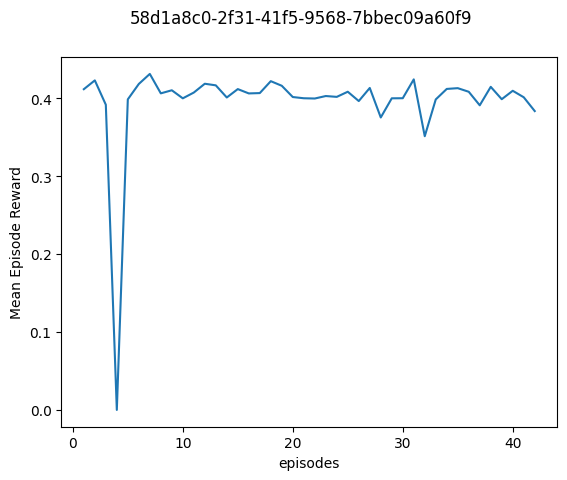

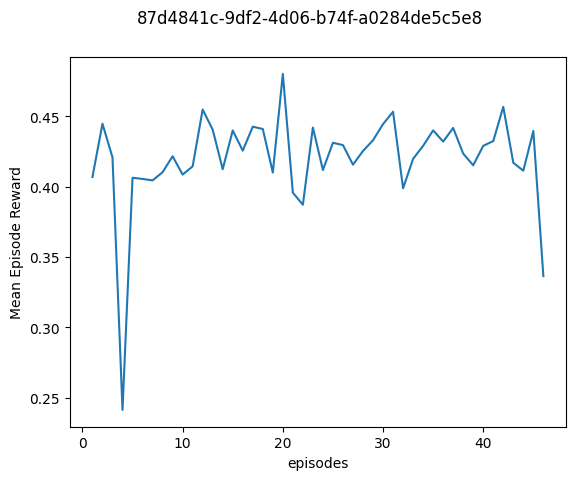

In [171]:
# Episode Reward by Run Id
for run_id in list(set([x[0] for x in df_group.index])):
    df_group[run_id].plot(subplots=True, title=run_id)
    plt.ylabel('Mean Episode Reward')
    plt.show()

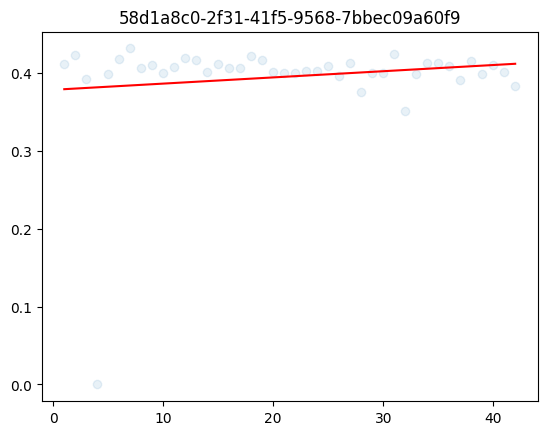

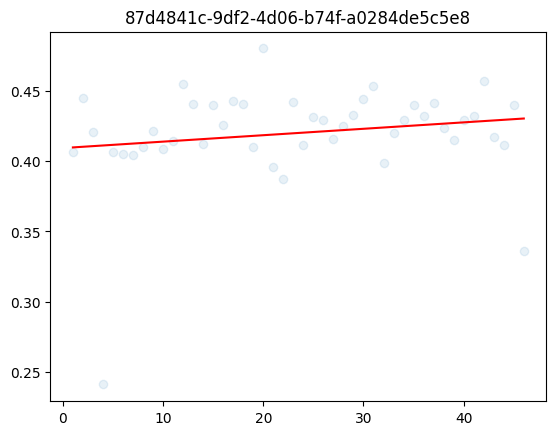

In [172]:
# Episode Reward by Run Id with Trend
for run_id in list(set([x[0] for x in df_group.index])):
    plt.scatter(df_group[run_id].index, df_group[run_id].reset_index()['reward'], alpha=0.1)
    plt.title(run_id)
    if len(df_group[run_id]) > 10:
        slope, intercept = np.polyfit(df_group[run_id].index, df_group[run_id].reset_index()['reward'], 1)
        plt.plot(df_group[run_id].index, slope * df_group[run_id].index + intercept, 'r')

    plt.show()

In [176]:
# Process observation data
df_obs = pd.DataFrame(data=[[v[0] for v in list(x.values())] for x in df['composabl_obs'].values], columns=[list(df['composabl_obs'][0].keys())])
df_obs['episode'] = df['episodes']
df_obs['run_id'] = df['run_id']
df_obs.columns = [x[0] for x in list(df_obs.columns)]

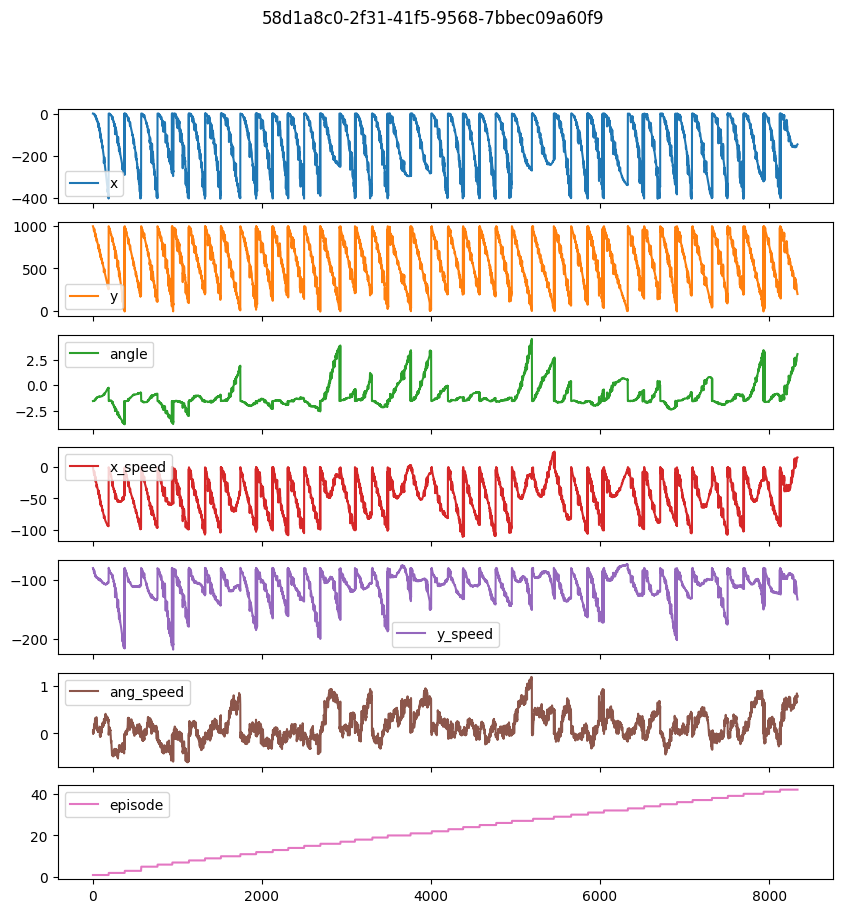

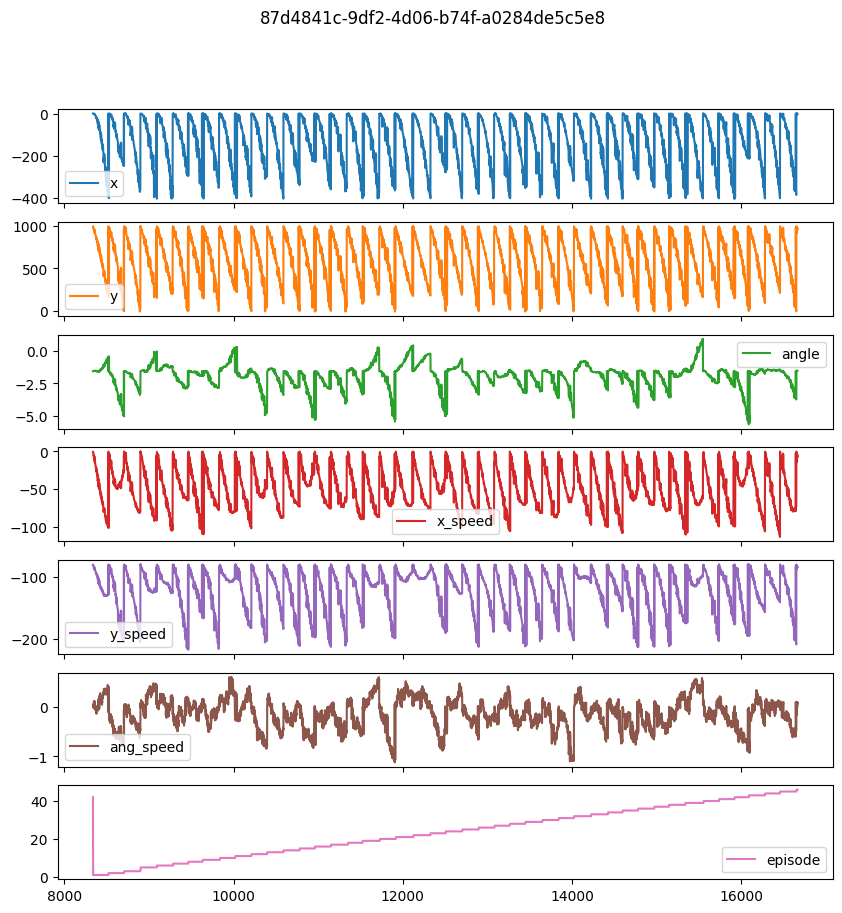

In [178]:
# Plot Observation data by run_ids
for run in df_obs.run_id.unique():
    df_obs[df_obs['run_id'] == run].plot(subplots=True, figsize=(10,10), title=f"Run id {run}")

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

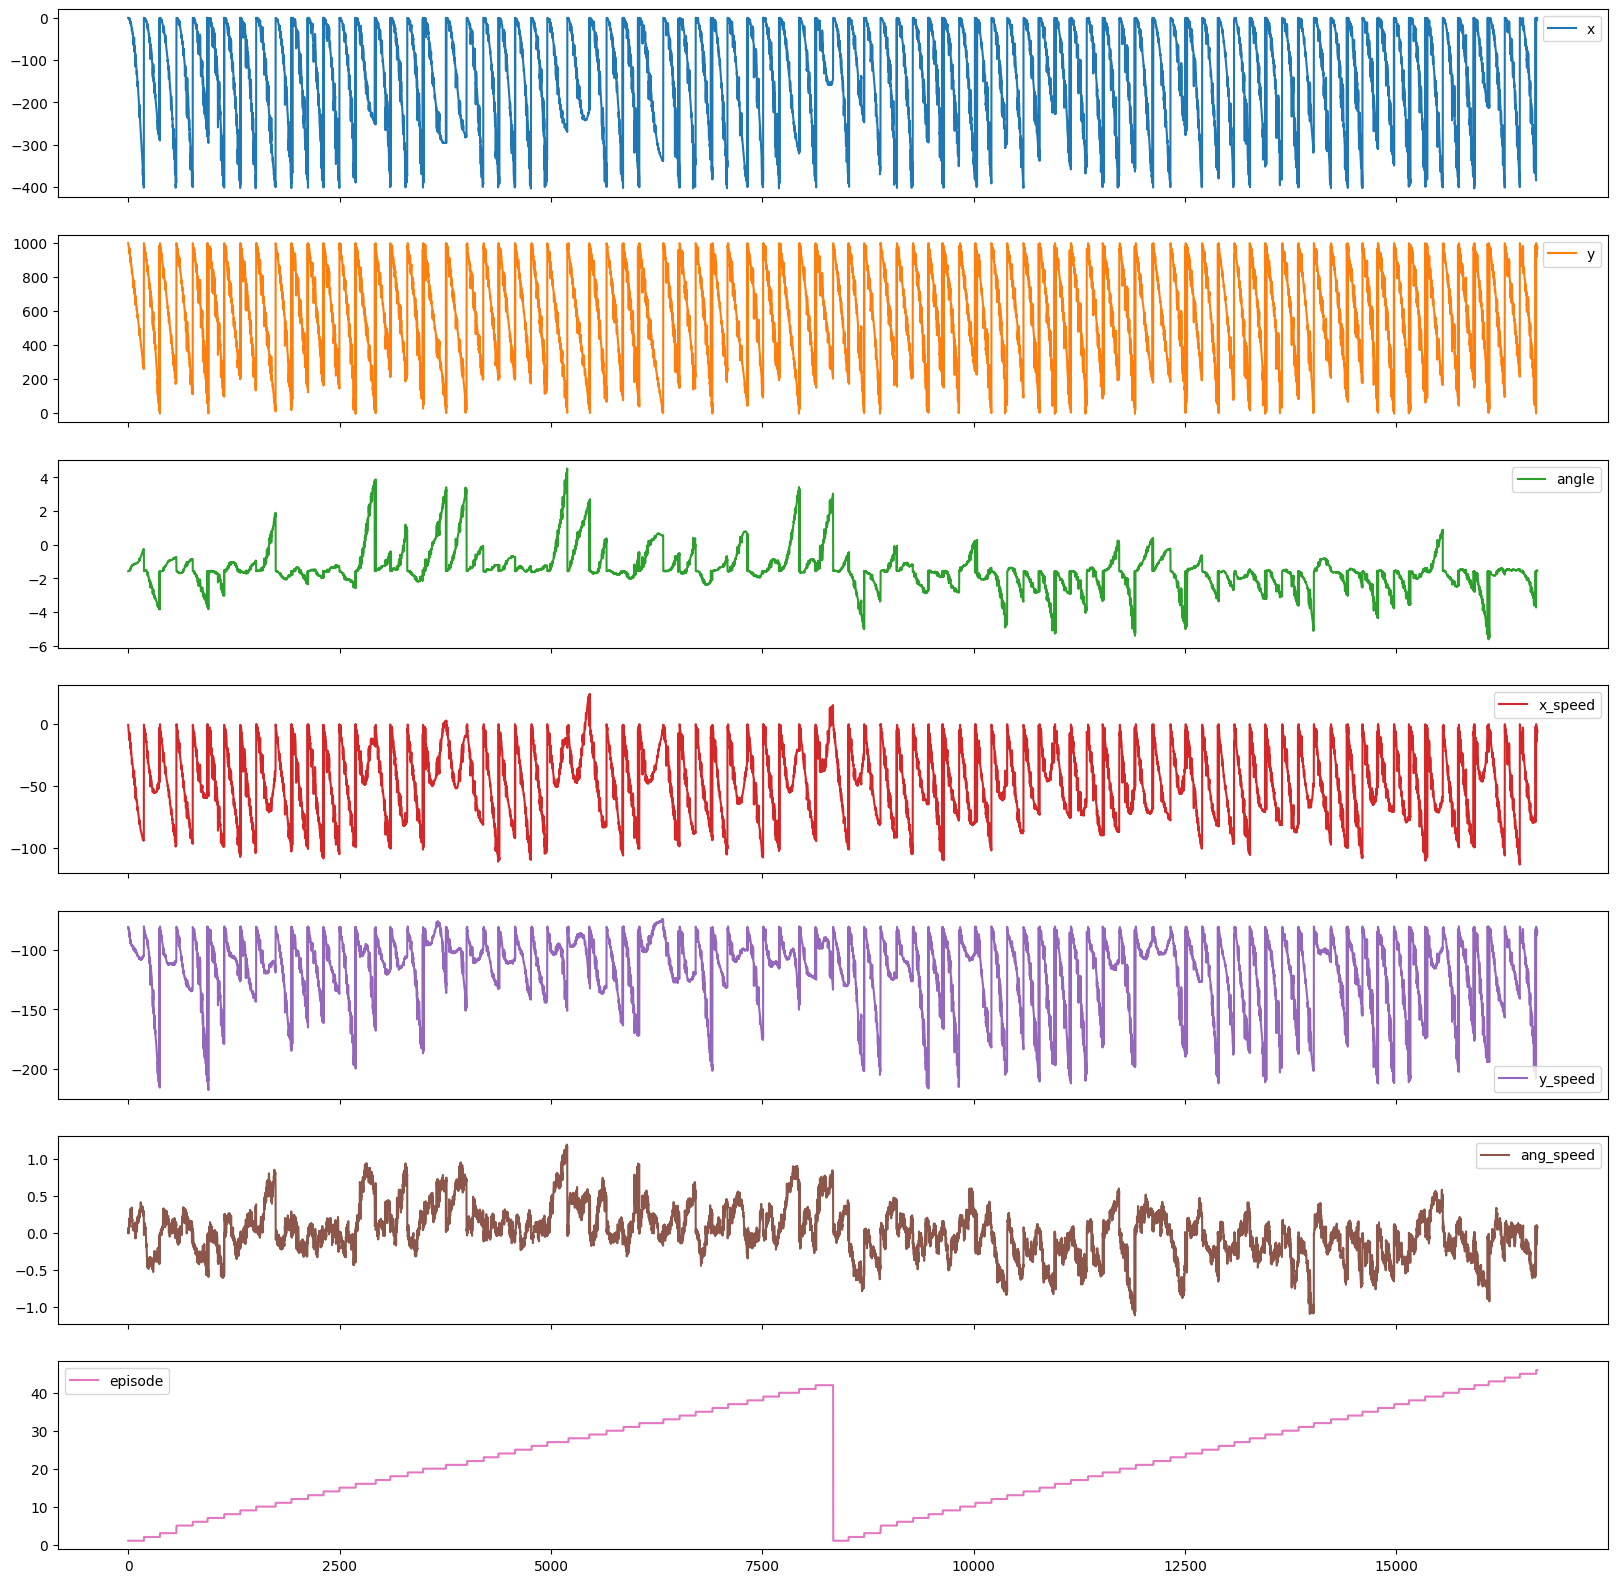

In [174]:
# Plot Observation data for all run_ids and episodes
df_obs.plot(subplots=True, figsize=(10,10))

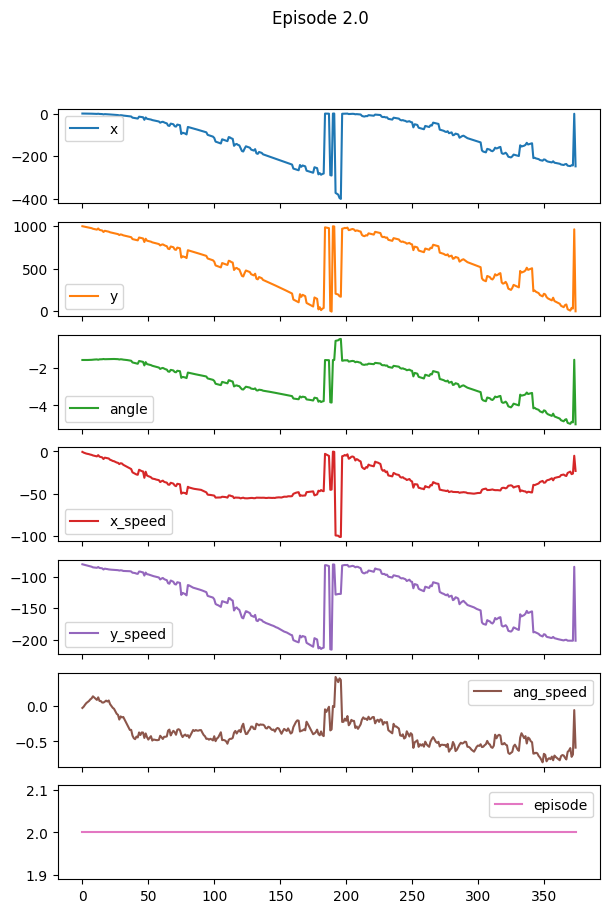

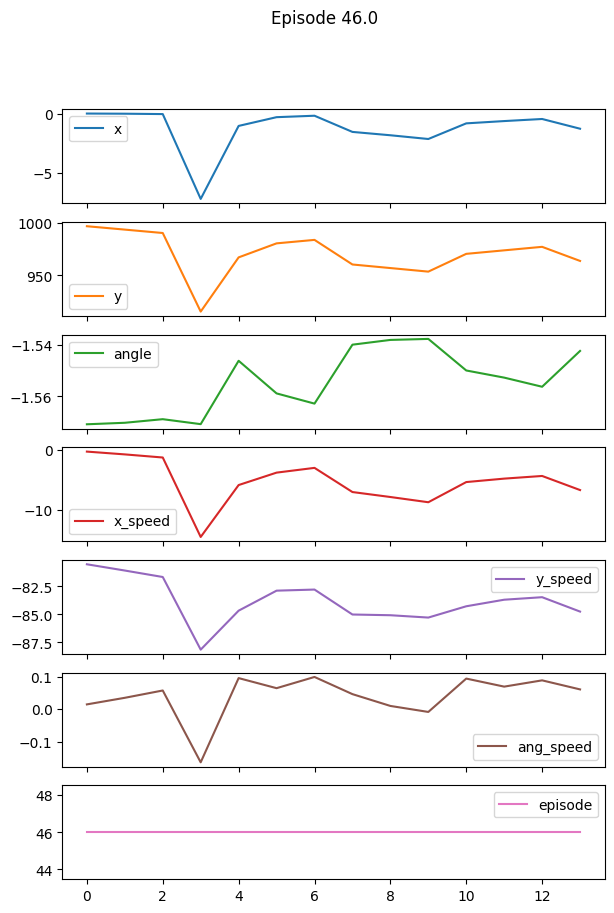

In [179]:
# Plot Observation data per episode - Plotting first and last
for ep in [list(df_obs.episode.unique())[1] ,list(df_obs.episode.unique())[-1]]:
    if ep > 0:
        df_obs[df_obs['episode']==ep].reset_index(drop=True).plot(subplots=True, figsize=(7,10), title=f"Episode {ep}")

# Analyze each run

In [183]:
# Choose a run id - using the last one
run_id = df['run_id'].iloc[-1]

In [186]:
print('Max Episode: ', df['episodes'].max())

# choose an episode to analyze - using the last one
episode = df['episodes'].max()

Max Episode:  46.0


In [187]:
# Filter dataframe by run if
df_filter = df[df['run_id'] == run_id]

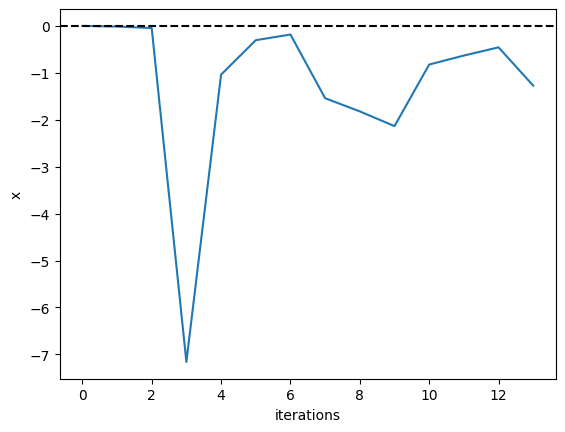

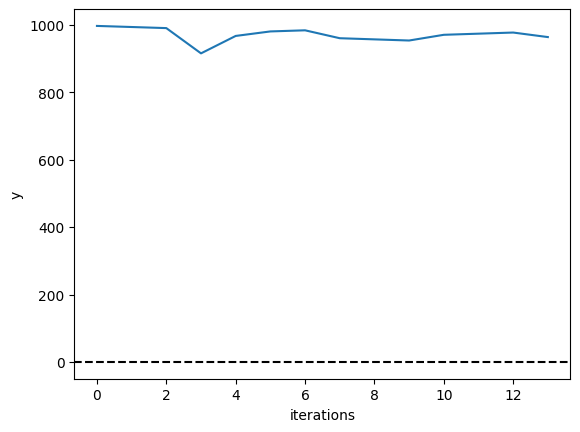

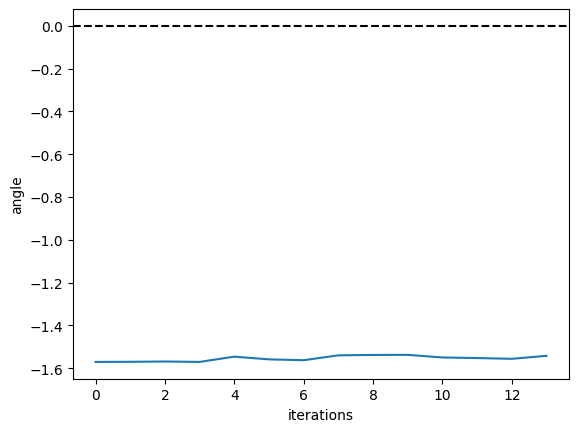

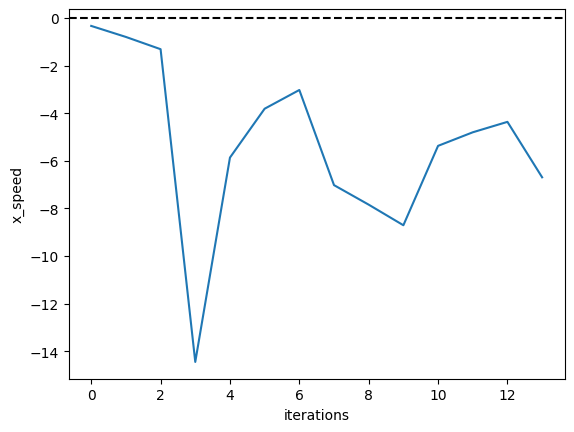

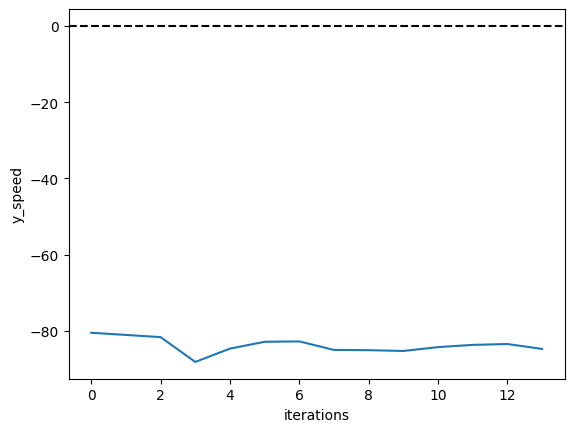

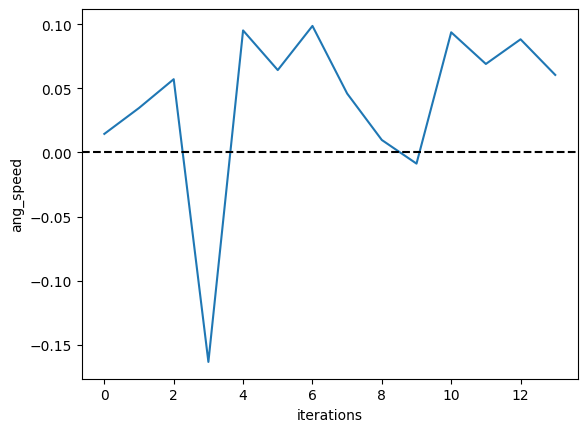

In [210]:
# Analyze how each variable is doing compared to their targets
target = 0
for v in list(df_filter['composabl_obs'].iloc[0].keys()):
    plt.plot(df_filter[df_filter['episodes'] == episode]['composabl_obs'].reset_index(drop=True).apply(lambda x: x[v][0]))
    plt.axhline(target, color='black', linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel(v)
    plt.show()